In [2]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np

In [3]:
menu_items = pd.read_csv("MenuItem.csv")
menu_pages = pd.read_csv("MenuPage.csv")
menus = pd.read_csv("Menu.csv")
dishes = pd.read_csv("Dish.csv")

In [15]:
menu_items = menu_items.merge(dishes[['id', 'name']], left_on='dish_id', right_on='id', suffixes=('', '_dish'))
menu_items = menu_items.merge(menu_pages[['id', 'menu_id']], left_on='menu_page_id', right_on='id', suffixes=('', '_page'))
menu_items = menu_items.merge(menus[['id', 'date']], left_on='menu_id', right_on='id', suffixes=('', '_menu'))

#change to year
menu_items["year_extracted"] = pd.to_datetime(menu_items["date"], errors='coerce').dt.year.astype("Int64")
#remove rows missing data
menu_items = menu_items.dropna(subset=["price", "year", "name"])

In [26]:
#create categories
def categorize(name):
    
    name = str(name).lower()
    
    luxury = ["caviar", "foie", "truffle", "lobster", "turtle", "pate", "mumm", "champagne", "quenelle", "duxelle"]
    staple = ["soup", "gumbo", "rice", "potato", "apple", "banana", "onion", "beef", "milk", "oats"]

    for kw in luxury:
        if kw in name:
            return "luxury"
    for kw in staple:
        if kw in name:
            return "staple"
    return "unknown"

menu_items["category"] = menu_items["name"].apply(categorize)
menu_items = menu_items[menu_items["category"].isin(["luxury", "staple"])]
print(menu_items['category'].value_counts())  # see count luxury vs. staple

category
staple    110787
luxury     26137
Name: count, dtype: int64


In [36]:
#Adjust for inflation 
cpi_raw = {1890: 9.1, 1900: 8.4, 1910: 9.5, 1920: 20.0, 1930: 17.1, 1940: 14.0}

years = np.array(list(cpi_raw.keys()))
cpi_vals = np.array(list(cpi_raw.values()))

#func to extrapolate in between year values 
cpi_func = interp1d(years, cpi_vals, kind='linear', fill_value='extrapolate')

menu_items["cpi"] = menu_items["year_extracted"].apply(lambda y: cpi_func(y))
menu_items["real_price"] = menu_items["price"] / menu_items["cpi"] * 100

In [39]:
counts = (
    menu_items
    .groupby("year_extracted")["category"]
    .value_counts()
    .unstack()
    .fillna(0)
    .astype(int)
)
print(counts)

category        luxury  staple
year_extracted                
1851                 7       0
1852                17       1
1855                 1       0
1856                16      23
1857                 7       0
...                ...     ...
2004                 0       5
2005                10       3
2006                 5       6
2008                16       9
2012                42      19

[132 rows x 2 columns]


In [54]:
z = 60  # minimum count for both categories

valid_years = counts[
    (counts["luxury"] >= z) & (counts["staple"] >= z)
].index

menu_items_filtered = menu_items[menu_items["year_extracted"].isin(valid_years)]

filtered_counts = counts.loc[valid_years]
filtered_counts = filtered_counts[(filtered_counts.index >= 1890) & (filtered_counts.index <= 1940)]

print(filtered_counts)

category        luxury  staple
year_extracted                
1892               121     437
1893                66      96
1896               114     206
1898                79     192
1899               142     450
1900              4069   13477
1901              1364    4778
1905               406    1290
1906               688    2164
1907               413    1800
1912               457    1297
1913              1141    6690
1914              2720   12727
1915               431    2036
1916               158     686
1917              2504   12746
1918              2522    7879
1919               224    1088
1920               204     901
1933              1517   10374
1937               178    1664
1938               215     815
1939               207    1103
1940               274    1634


In [55]:
price_by_year = (
    menu_items_filtered
    .groupby(["year", "category"])["real_price"]
    .mean()
    .unstack()
)

price_by_year["premium"] = price_by_year["luxury"] - price_by_year["staple"]
price_by_year = price_by_year[(price_by_year.index >= 1890) & (price_by_year.index <= 1940)]
price_by_year = price_by_year.dropna()
print(price_by_year)

category     luxury     staple    premium
year                                     
1892       9.025421   3.774722   5.250698
1893      14.691345   4.183071  10.508275
1896      13.304430   5.732406   7.572025
1898      62.809415  28.642784  34.166631
1899      12.683539   3.974813   8.708726
1900      20.221000   8.939269  11.281732
1901      19.543335   6.512986  13.030349
1905      16.201117  10.876705   5.324412
1906      36.046832  13.971908  22.074924
1907      34.764378   7.354901  27.409477
1912      79.192447  20.132933  59.059514
1913      20.306021   9.112190  11.193831
1914       9.487012   3.173637   6.313375
1915       6.332140   2.086977   4.245164
1916       8.491428   1.648799   6.842629
1917       8.903096   3.001372   5.901724
1918      10.337211   2.788801   7.548411
1919       7.535102   2.128521   5.406581
1920      19.235294   2.946171  16.289123
1933       8.688502   3.614546   5.073956
1937       8.929311   3.799784   5.129527
1938      47.086183   7.349123  39

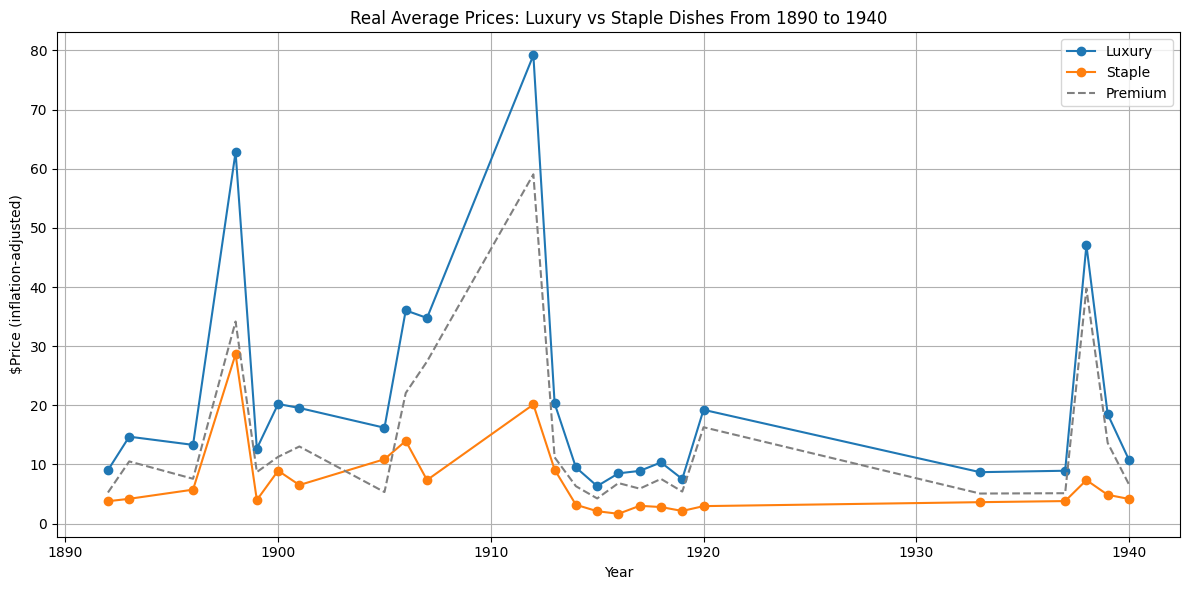

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(price_by_year.index, price_by_year["luxury"], label="Luxury", marker='o')
plt.plot(price_by_year.index, price_by_year["staple"], label="Staple", marker='o')
plt.plot(price_by_year.index, price_by_year["premium"], label="Premium", linestyle='--', color='gray')

plt.title("Real Average Prices: Luxury vs Staple Dishes From 1890 to 1940")
plt.xlabel("Year")
plt.ylabel("$Price (inflation-adjusted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()